In [1]:
# check if cuda is available
import torch
torch.cuda.is_available()


True

In [44]:
import torch
import pandas as pd
import elmo_dataset as ds
import nltk
import unicodedata
import re

In [46]:
def preprocess(csv):
    df = pd.read_csv(csv)

    df = df.dropna()
    df = df.reset_index(drop=True)

    def normalize_unicode(s):
        return unicodedata.normalize('NFD', s)

    def preprocess_text(text):
        text = normalize_unicode(text)
        text = re.sub(r"(.)(\1{2,})", r"\1", text)
        text = re.sub(r"[^a-zA-Z.,!?]+", " ", text)
        text = text.strip().lower()
        return text

    nltk.download('punkt')

    df['Description'] = df['Description'].apply(preprocess_text)
    df['Description'] = df['Description'].apply(nltk.word_tokenize)
    
    return df

train_df = preprocess('train.csv')
test_df = preprocess('test.csv')

[nltk_data] Downloading package punkt to /home/swetha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/swetha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
PRE_TRAIN_SET = 8000
PRE_VAL_SET = 2000
DOWNSTREAM_TRAIN_SET = 80000
DOWNSTREAM_VAL_SET = 20000

In [4]:
train_set = list(train_df['Description'])
pre_train_set = train_set[:PRE_TRAIN_SET]
pre_val_set = train_set[PRE_TRAIN_SET:PRE_TRAIN_SET+PRE_VAL_SET]

In [5]:
vocab = ds.ELMO_Dataset.create_vocab(train_set)
word_to_ix = {word: idx for idx, word in enumerate(vocab)}
print(len(word_to_ix))

59352


In [6]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=word_to_ix['<pad>'])
    lengths = torch.LongTensor([len(x) for x in batch])

    input_tensor = torch.LongTensor(padded_batch[:, :-1])
    target_truth = torch.LongTensor(padded_batch[:, 1:])

    return input_tensor, target_truth, lengths - 1

In [7]:
from torch.utils.data import DataLoader

forward_pre_train_dataset = ds.ELMO_Dataset(pre_train_set, word_to_ix, 'Forward')
forward_pre_val_dataset = ds.ELMO_Dataset(pre_val_set, word_to_ix, 'Forward')

backward_pre_train_dataset = ds.ELMO_Dataset(pre_train_set, word_to_ix, 'Backward')
backward_pre_val_dataset = ds.ELMO_Dataset(pre_val_set, word_to_ix, 'Backward')

batch_size = 32

forward_pre_train_loader = DataLoader(forward_pre_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
forward_pre_val_loader = DataLoader(forward_pre_val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)

backward_pre_train_loader = DataLoader(backward_pre_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
backward_pre_val_loader = DataLoader(backward_pre_val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)

In [8]:
import gensim
import gensim.downloader

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [9]:
import numpy as np

def embedding_matrix(word_to_ix, glove_vectors):
    embedding_dim = glove_vectors.vector_size
    embedding_matrix = np.zeros((len(word_to_ix), embedding_dim))

    average_vector = np.mean(glove_vectors.vectors, axis=0)

    special_token_embeddings = {
        '<pad>': np.zeros(embedding_dim),
        '<unk>': average_vector,
        '<sos>': np.random.randn(embedding_dim),
        '<eos>': np.random.randn(embedding_dim)
    }

    for word, i in word_to_ix.items():
        if word in glove_vectors:
            embedding_vector = glove_vectors[word]
        else:
            embedding_vector = special_token_embeddings.get(word, average_vector)

        embedding_matrix[i] = embedding_vector

    print(embedding_matrix.shape)

    return torch.FloatTensor(embedding_matrix)

In [10]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ELMO(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout, filename=None):
        super(ELMO, self).__init__()

        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.forward_lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.backward_lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.forward_linear = nn.Linear(hidden_dim, embedding_matrix.shape[0])
        self.backward_linear = nn.Linear(hidden_dim, embedding_matrix.shape[0])

        if filename:
            self.load_state_dict(torch.load(filename), strict=False)

    def forward(self, input_tensor, lengths, forward):
        embedded = self.embedding(input_tensor)
        output = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        if forward:
            output, (h_n, c_n) = self.forward_lstm(output, None)
            output, _ = pad_packed_sequence(output, batch_first=True)
            output = self.forward_linear(output)
        else:
            output, (h_n, c_n) = self.backward_lstm(output, None)
            output, _ = pad_packed_sequence(output, batch_first=True)
            output = self.backward_linear(output)

        return output, h_n, c_n, embedded

In [11]:
from tqdm import tqdm

def run_epoch(model, data_loader, loss_fn, epoch, forward, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    total_loss = 0
    p_bar = tqdm(data_loader)

    for (input_tensor, target_truth, lengths) in p_bar:

        input_tensor = input_tensor.cuda()
        target_truth = target_truth.cuda()

        output, _, _, _= model(input_tensor, lengths, forward)
        output = output.reshape(-1, output.shape[2])

        target_truth = target_truth.reshape(-1)
        loss = loss_fn(output, target_truth)
        total_loss += loss.item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = total_loss / len(data_loader)

        p_bar.set_description(f'{"T" if optimizer else "V"} Loss: {mean_loss:.4f}, count: {epoch}')

    return mean_loss

In [12]:
import torch.nn as nn


def train(optimizer, embedding_dimension, hidden_dimension, dropout_rate, learning_rate):
    num_epochs = 50

    glove_vectors = gensim.downloader.load(f'glove-wiki-gigaword-{embedding_dimension}')
    loss_fn = nn.CrossEntropyLoss(ignore_index=word_to_ix['<pad>'])

    model = ELMO(embedding_matrix(word_to_ix, glove_vectors), hidden_dimension, 1, dropout_rate)

    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=learning_rate)

    model.cuda()

    best_val_loss = float('inf')

    all_val_loss = []
    all_train_loss = []

    for epoch in range(num_epochs):

        forward_train_loss = run_epoch(model, forward_pre_train_loader, loss_fn, epoch+1, 1, optimizer)
        backward_train_loss = run_epoch(model, backward_pre_train_loader, loss_fn, epoch+1, 0, optimizer)

        with torch.no_grad():
            forward_val_loss = run_epoch(model, forward_pre_val_loader, loss_fn, epoch+1, 1)
            backward_val_loss = run_epoch(model, backward_pre_val_loader, loss_fn, epoch+1, 0)

        print('Epoch: {}, F Train Loss: {:.4f}, F Val Loss: {:.4f}'.format(epoch+1, forward_train_loss, forward_val_loss))
        print('Epoch: {}, B Train Loss: {:.4f}, B Val Loss: {:.4f}'.format(epoch+1, backward_train_loss, backward_val_loss))
        average_train_loss = (forward_train_loss + backward_train_loss) / 2
        average_val_loss = (forward_val_loss + backward_val_loss) / 2

        all_train_loss.append(average_train_loss)
        all_val_loss.append(average_val_loss)
        print('Average Train Loss: {:.4f}, Average Val Loss: {:.4f}'.format(average_train_loss, average_val_loss))
        print('-------------------------------------------------------')

        if average_val_loss < best_val_loss:
            counter = 0
            best_val_loss = average_val_loss
            torch.save(model.state_dict(), 'best_elmo_model.pth')
        else:
            counter += 1
            if counter == 3:
                break

    return all_train_loss, all_val_loss

In [13]:
all_emlo_train_loss, all_elmo_val_loss = train('Adam', 100, 100, 0.2, 0.001)

(59352, 100)


/home/swetha/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
V Loss: 7.1156, count: 1: 100%|██████████| 63/63 [00:01<00:00, 38.39it/s]


Epoch: 1, F Train Loss: 7.5116, F Val Loss: 7.1333
Epoch: 1, B Train Loss: 7.5147, B Val Loss: 7.1156
Average Train Loss: 7.5132, Average Val Loss: 7.1245
-------------------------------------------------------


V Loss: 6.9417, count: 2: 100%|██████████| 63/63 [00:01<00:00, 36.10it/s]


Epoch: 2, F Train Loss: 6.8360, F Val Loss: 6.9684
Epoch: 2, B Train Loss: 6.8181, B Val Loss: 6.9417
Average Train Loss: 6.8271, Average Val Loss: 6.9550
-------------------------------------------------------


V Loss: 6.7535, count: 3: 100%|██████████| 63/63 [00:01<00:00, 36.28it/s]


Epoch: 3, F Train Loss: 6.5901, F Val Loss: 6.7572
Epoch: 3, B Train Loss: 6.5738, B Val Loss: 6.7535
Average Train Loss: 6.5819, Average Val Loss: 6.7554
-------------------------------------------------------


V Loss: 6.5741, count: 4: 100%|██████████| 63/63 [00:01<00:00, 35.00it/s]


Epoch: 4, F Train Loss: 6.3381, F Val Loss: 6.5770
Epoch: 4, B Train Loss: 6.3320, B Val Loss: 6.5741
Average Train Loss: 6.3350, Average Val Loss: 6.5755
-------------------------------------------------------


V Loss: 6.4398, count: 5: 100%|██████████| 63/63 [00:01<00:00, 35.18it/s]


Epoch: 5, F Train Loss: 6.1149, F Val Loss: 6.4242
Epoch: 5, B Train Loss: 6.1165, B Val Loss: 6.4398
Average Train Loss: 6.1157, Average Val Loss: 6.4320
-------------------------------------------------------


V Loss: 6.3362, count: 6: 100%|██████████| 63/63 [00:01<00:00, 35.84it/s]


Epoch: 6, F Train Loss: 5.9191, F Val Loss: 6.3171
Epoch: 6, B Train Loss: 5.9415, B Val Loss: 6.3362
Average Train Loss: 5.9303, Average Val Loss: 6.3267
-------------------------------------------------------


V Loss: 6.2663, count: 7: 100%|██████████| 63/63 [00:01<00:00, 36.39it/s]


Epoch: 7, F Train Loss: 5.7535, F Val Loss: 6.2266
Epoch: 7, B Train Loss: 5.7938, B Val Loss: 6.2663
Average Train Loss: 5.7736, Average Val Loss: 6.2464
-------------------------------------------------------


V Loss: 6.2040, count: 8: 100%|██████████| 63/63 [00:01<00:00, 36.27it/s]


Epoch: 8, F Train Loss: 5.6123, F Val Loss: 6.1541
Epoch: 8, B Train Loss: 5.6646, B Val Loss: 6.2040
Average Train Loss: 5.6385, Average Val Loss: 6.1791
-------------------------------------------------------


V Loss: 6.1469, count: 9: 100%|██████████| 63/63 [00:01<00:00, 35.93it/s]


Epoch: 9, F Train Loss: 5.4871, F Val Loss: 6.1093
Epoch: 9, B Train Loss: 5.5469, B Val Loss: 6.1469
Average Train Loss: 5.5170, Average Val Loss: 6.1281
-------------------------------------------------------


V Loss: 6.1045, count: 10: 100%|██████████| 63/63 [00:01<00:00, 35.87it/s]


Epoch: 10, F Train Loss: 5.3729, F Val Loss: 6.0589
Epoch: 10, B Train Loss: 5.4361, B Val Loss: 6.1045
Average Train Loss: 5.4045, Average Val Loss: 6.0817
-------------------------------------------------------


V Loss: 6.0683, count: 11: 100%|██████████| 63/63 [00:01<00:00, 35.65it/s]


Epoch: 11, F Train Loss: 5.2685, F Val Loss: 6.0257
Epoch: 11, B Train Loss: 5.3338, B Val Loss: 6.0683
Average Train Loss: 5.3011, Average Val Loss: 6.0470
-------------------------------------------------------


V Loss: 6.0423, count: 12: 100%|██████████| 63/63 [00:01<00:00, 35.53it/s]


Epoch: 12, F Train Loss: 5.1729, F Val Loss: 5.9961
Epoch: 12, B Train Loss: 5.2396, B Val Loss: 6.0423
Average Train Loss: 5.2062, Average Val Loss: 6.0192
-------------------------------------------------------


V Loss: 6.0130, count: 13: 100%|██████████| 63/63 [00:01<00:00, 34.93it/s]


Epoch: 13, F Train Loss: 5.0832, F Val Loss: 5.9714
Epoch: 13, B Train Loss: 5.1509, B Val Loss: 6.0130
Average Train Loss: 5.1170, Average Val Loss: 5.9922
-------------------------------------------------------


V Loss: 5.9874, count: 14: 100%|██████████| 63/63 [00:01<00:00, 34.79it/s]


Epoch: 14, F Train Loss: 5.0025, F Val Loss: 5.9432
Epoch: 14, B Train Loss: 5.0681, B Val Loss: 5.9874
Average Train Loss: 5.0353, Average Val Loss: 5.9653
-------------------------------------------------------


V Loss: 5.9751, count: 15: 100%|██████████| 63/63 [00:01<00:00, 35.14it/s]


Epoch: 15, F Train Loss: 4.9260, F Val Loss: 5.9354
Epoch: 15, B Train Loss: 4.9911, B Val Loss: 5.9751
Average Train Loss: 4.9585, Average Val Loss: 5.9553
-------------------------------------------------------


V Loss: 5.9625, count: 16: 100%|██████████| 63/63 [00:01<00:00, 34.88it/s]


Epoch: 16, F Train Loss: 4.8529, F Val Loss: 5.9254
Epoch: 16, B Train Loss: 4.9155, B Val Loss: 5.9625
Average Train Loss: 4.8842, Average Val Loss: 5.9440
-------------------------------------------------------


V Loss: 5.9548, count: 17: 100%|██████████| 63/63 [00:01<00:00, 33.96it/s]


Epoch: 17, F Train Loss: 4.7847, F Val Loss: 5.9221
Epoch: 17, B Train Loss: 4.8471, B Val Loss: 5.9548
Average Train Loss: 4.8159, Average Val Loss: 5.9385
-------------------------------------------------------


V Loss: 5.9394, count: 18: 100%|██████████| 63/63 [00:01<00:00, 34.59it/s]


Epoch: 18, F Train Loss: 4.7193, F Val Loss: 5.9137
Epoch: 18, B Train Loss: 4.7816, B Val Loss: 5.9394
Average Train Loss: 4.7504, Average Val Loss: 5.9266
-------------------------------------------------------


V Loss: 5.9297, count: 19: 100%|██████████| 63/63 [00:01<00:00, 34.62it/s]


Epoch: 19, F Train Loss: 4.6592, F Val Loss: 5.9092
Epoch: 19, B Train Loss: 4.7193, B Val Loss: 5.9297
Average Train Loss: 4.6892, Average Val Loss: 5.9195
-------------------------------------------------------


V Loss: 5.9404, count: 20: 100%|██████████| 63/63 [00:01<00:00, 33.95it/s]


Epoch: 20, F Train Loss: 4.6024, F Val Loss: 5.9161
Epoch: 20, B Train Loss: 4.6613, B Val Loss: 5.9404
Average Train Loss: 4.6319, Average Val Loss: 5.9283
-------------------------------------------------------


V Loss: 5.9353, count: 21: 100%|██████████| 63/63 [00:01<00:00, 34.77it/s]


Epoch: 21, F Train Loss: 4.5464, F Val Loss: 5.9119
Epoch: 21, B Train Loss: 4.6047, B Val Loss: 5.9353
Average Train Loss: 4.5756, Average Val Loss: 5.9236
-------------------------------------------------------


V Loss: 5.9396, count: 22: 100%|██████████| 63/63 [00:01<00:00, 34.44it/s]


Epoch: 22, F Train Loss: 4.4953, F Val Loss: 5.9191
Epoch: 22, B Train Loss: 4.5512, B Val Loss: 5.9396
Average Train Loss: 4.5232, Average Val Loss: 5.9293
-------------------------------------------------------


In [14]:
from torch.utils.data import DataLoader, Dataset

class Downstream_Dataset(Dataset):
    def __init__(self, data_set, labels, word_to_ix):
        self.data_set = [['<sos>'] + x + ['<eos>'] for x in data_set]
        self.word_to_ix = word_to_ix
        self.indexed_data = [[word_to_ix.get(word, word_to_ix['<unk>']) for word in sentence] for sentence in self.data_set]
        self.labels = labels

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        return torch.tensor(self.indexed_data[idx]), torch.tensor(self.indexed_data[idx][::-1]), torch.tensor(self.labels[idx])

In [24]:
from torch.nn.utils.rnn import pad_sequence

def downstream_collate_fn(batch):
    x_forward = pad_sequence([x[0] for x in batch], batch_first=True, padding_value=word_to_ix['<pad>'])
    x_backward = pad_sequence([x[1] for x in batch], batch_first=True, padding_value=word_to_ix['<pad>'])

    lengths = torch.LongTensor([len(x[0]) for x in batch])
    labels = torch.LongTensor([x[2] - 1 for x in batch])

    return x_forward, x_backward, lengths, labels

In [25]:
train_labels = list(train_df['Class Index'])

downstream_train_set = train_set[PRE_TRAIN_SET+PRE_VAL_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET]
downstream_train_labels = train_labels[PRE_TRAIN_SET+PRE_VAL_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET]
downstream_val_set = train_set[PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET+DOWNSTREAM_VAL_SET]
downstream_val_labels = train_labels[PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET+DOWNSTREAM_VAL_SET]

In [26]:
downstream_train_dataset = Downstream_Dataset(downstream_train_set, downstream_train_labels, word_to_ix)
downstream_val_dataset = Downstream_Dataset(downstream_val_set, downstream_val_labels, word_to_ix)

downstream_train_loader = DataLoader(downstream_train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2, collate_fn=downstream_collate_fn)
downstream_val_loader = DataLoader(downstream_val_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2, collate_fn=downstream_collate_fn)

In [27]:
import torch.nn as nn

class Downstream_Model(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout):
        super(Downstream_Model, self).__init__()

        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.elmo = ELMO(embedding_matrix, hidden_dim, num_layers, dropout, 'best_elmo_model.pth')

        for param in self.elmo.parameters():
            param.requires_grad = False

        self.delta = nn.Parameter(torch.randn(1, 3))
        self.linear = nn.Linear(hidden_dim * 2, 4)

    def forward(self, forward_input, backward_input, lengths):
        _, forward_h_n, forward_c_n, input = self.elmo(forward_input, lengths, 1)
        _, backward_h_n, backward_c_n, _ = self.elmo(backward_input, lengths, 0)

        input = torch.mean(input, dim=1)

        forward_h_n = forward_h_n.permute(1, 0, 2)
        backward_h_n = backward_h_n.permute(1, 0, 2)
        forward_c_n = forward_c_n.permute(1, 0, 2)
        backward_c_n = backward_c_n.permute(1, 0, 2)

        hidden = torch.cat([forward_h_n, backward_h_n], dim=2)
        cell = torch.cat([forward_c_n, backward_c_n], dim=2)

        mean = (hidden + cell) / 2
        input = torch.cat([input] * mean.shape[1], dim=1).unsqueeze(1)

        mean = torch.cat([mean, input], dim=1)
        mean = (self.delta / (torch.sum(self.delta))) @ mean
        mean = mean.squeeze(0)

        output = self.linear(mean)
        return output

In [28]:
def calculate_accuracy(output, labels):
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

In [32]:
num_classes = 4

downstream_model = Downstream_Model(embedding_matrix(word_to_ix, glove_vectors), 100, 2, 0.2)
downstream_model = downstream_model.cuda()

def run_downstream_epoch(model, data_loader, loss_fn, epoch, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_accuracy = 0

    p_bar = tqdm(data_loader)

    for (x_forward, x_backward, lengths, labels) in p_bar:
        x_forward = x_forward.cuda()
        x_backward = x_backward.cuda()

        labels = labels.cuda()

        output = model(x_forward, x_backward, lengths)

        output = output.reshape(-1, output.shape[-1])

        loss = loss_fn(output, labels)
        total_loss += loss.item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy = calculate_accuracy(output, labels)
        total_accuracy += accuracy

        mean_loss = total_loss / len(data_loader)
        mean_accuracy = total_accuracy / len(data_loader)

        p_bar.set_description(f'{"T" if optimizer else "V"} Loss: {mean_loss:.4f}, count: {epoch}')

    return mean_loss, mean_accuracy

(59352, 100)


In [33]:
import torch.nn as nn

def train_downstream_classifier(optimizer):
    num_epochs = 100

    loss_fn = nn.CrossEntropyLoss(ignore_index=word_to_ix['<pad>'])

    optimizer = getattr(torch.optim, optimizer)(downstream_model.parameters(), lr=0.001)

    best_val_loss = float('inf')

    all_val_loss = []
    all_train_loss = []

    all_val_accuracy = []
    all_train_accuracy = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = run_downstream_epoch(downstream_model, downstream_train_loader, loss_fn, epoch+1, optimizer)
        all_train_loss.append(train_loss)
        all_train_accuracy.append(train_accuracy)

        with torch.no_grad():
            val_loss, val_accuracy = run_downstream_epoch(downstream_model, downstream_val_loader, loss_fn, epoch+1)
            all_val_loss.append(val_loss)
            all_val_accuracy.append(val_accuracy)

        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.4f}, Val Accuracy: {:.4f}'.format(epoch+1, train_loss, val_loss, train_accuracy, val_accuracy))

        if val_loss < best_val_loss:
            counter = 0
            best_val_loss = val_loss
            torch.save(downstream_model.state_dict(), 'best_downstream_model_.pth')
        else:
            counter += 1
            if counter == 3:
                break

    return all_train_loss, all_val_loss, all_train_accuracy, all_val_accuracy

In [38]:
all_downstream_train_loss, all_downstream_val_loss, all_downstream_train_accuracy, all_downstream_val_accuracy = train_downstream_classifier('Adam')

V Loss: 0.4135, count: 1: 100%|██████████| 625/625 [00:10<00:00, 58.03it/s]


Epoch: 1, Train Loss: 0.3933, Val Loss: 0.4135, Train Accuracy: 0.8627, Val Accuracy: 0.8502


V Loss: 0.3910, count: 2: 100%|██████████| 625/625 [00:10<00:00, 57.43it/s]


Epoch: 2, Train Loss: 0.3932, Val Loss: 0.3910, Train Accuracy: 0.8631, Val Accuracy: 0.8544


V Loss: 0.4031, count: 3: 100%|██████████| 625/625 [00:10<00:00, 57.83it/s]


Epoch: 3, Train Loss: 0.3916, Val Loss: 0.4031, Train Accuracy: 0.8633, Val Accuracy: 0.8570


V Loss: 0.3886, count: 4: 100%|██████████| 625/625 [00:10<00:00, 58.19it/s]


Epoch: 4, Train Loss: 0.3893, Val Loss: 0.3886, Train Accuracy: 0.8641, Val Accuracy: 0.8616


V Loss: 0.4595, count: 5: 100%|██████████| 625/625 [00:10<00:00, 58.23it/s]


Epoch: 5, Train Loss: 0.3887, Val Loss: 0.4595, Train Accuracy: 0.8639, Val Accuracy: 0.8262


V Loss: 0.3822, count: 6: 100%|██████████| 625/625 [00:10<00:00, 58.17it/s]


Epoch: 6, Train Loss: 0.3890, Val Loss: 0.3822, Train Accuracy: 0.8643, Val Accuracy: 0.8626


V Loss: 0.4229, count: 7: 100%|██████████| 625/625 [00:10<00:00, 57.59it/s]


Epoch: 7, Train Loss: 0.3888, Val Loss: 0.4229, Train Accuracy: 0.8636, Val Accuracy: 0.8422


V Loss: 0.4185, count: 8: 100%|██████████| 625/625 [00:10<00:00, 57.70it/s]


Epoch: 8, Train Loss: 0.3862, Val Loss: 0.4185, Train Accuracy: 0.8650, Val Accuracy: 0.8475


V Loss: 0.3790, count: 9: 100%|██████████| 625/625 [00:10<00:00, 57.99it/s]


Epoch: 9, Train Loss: 0.3865, Val Loss: 0.3790, Train Accuracy: 0.8658, Val Accuracy: 0.8632


V Loss: 0.3863, count: 10: 100%|██████████| 625/625 [00:10<00:00, 57.01it/s]


Epoch: 10, Train Loss: 0.3849, Val Loss: 0.3863, Train Accuracy: 0.8654, Val Accuracy: 0.8609


V Loss: 0.4091, count: 11: 100%|██████████| 625/625 [00:10<00:00, 57.11it/s]


Epoch: 11, Train Loss: 0.3847, Val Loss: 0.4091, Train Accuracy: 0.8651, Val Accuracy: 0.8524


V Loss: 0.3829, count: 12: 100%|██████████| 625/625 [00:10<00:00, 57.53it/s]

Epoch: 12, Train Loss: 0.3845, Val Loss: 0.3829, Train Accuracy: 0.8656, Val Accuracy: 0.8617


In [39]:
import pickle

results_dict = {
    'elmo_train_loss': all_emlo_train_loss,
    'elmo_val_loss': all_elmo_val_loss,
    'downstream_train_loss': all_downstream_train_loss,
    'downstream_val_loss': all_downstream_val_loss,
    'downstream_train_accuracy': all_downstream_train_accuracy,
    'downstream_val_accuracy': all_downstream_val_accuracy
}

with open('results.pkl', 'wb') as pickle_file:
  pickle.dump(results_dict, pickle_file)

In [47]:
# create testing dataset

test_set = list(test_df['Description'])
test_labels = list(test_df['Class Index'])

test_dataset = Downstream_Dataset(test_set, test_labels, word_to_ix)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2, collate_fn=downstream_collate_fn)

In [52]:
# test using the testing dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
    
def test_downstream_classifier():
    loss_fn = nn.CrossEntropyLoss(ignore_index=word_to_ix['<pad>'])
    downstream_model.load_state_dict(torch.load('best_downstream_model_.pth'))
    downstream_model.eval()
    
    pred_labels = []
    true_labels = []
    total_loss = []

    with torch.no_grad():
        for x_forward, x_backward, lengths, labels in test_loader:
            x_forward = x_forward.cuda()
            x_backward = x_backward.cuda()
            labels = labels.cuda()

            output = downstream_model(x_forward, x_backward, lengths)

            output = output.reshape(-1, output.shape[-1])

            loss = loss_fn(output, labels)
            total_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            pred_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    mean_loss = np.mean(total_loss)
    
    print('Test Loss: {:.4f}'.format(mean_loss))
    
    # classification report and confusion matrix
    print(classification_report(true_labels, pred_labels))
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    

Test Loss: 0.4017
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1900
           1       0.92      0.95      0.94      1900
           2       0.78      0.85      0.82      1900
           3       0.84      0.79      0.81      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



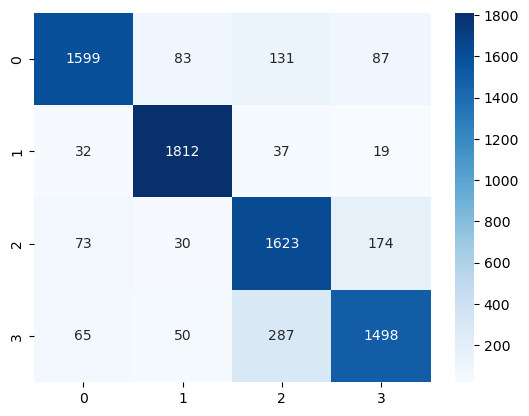

In [54]:
test_downstream_classifier()